<a href="https://colab.research.google.com/github/Raghu290/sparkML/blob/master/ac_gan_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import psutil ; print(list(psutil.virtual_memory())[0:2])

import numpy as np
import pandas as pd
import sklearn
import collections
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()
print(list(psutil.virtual_memory())[0:2])

[13653602304, 12772036608]
[13653602304, 12751597568]


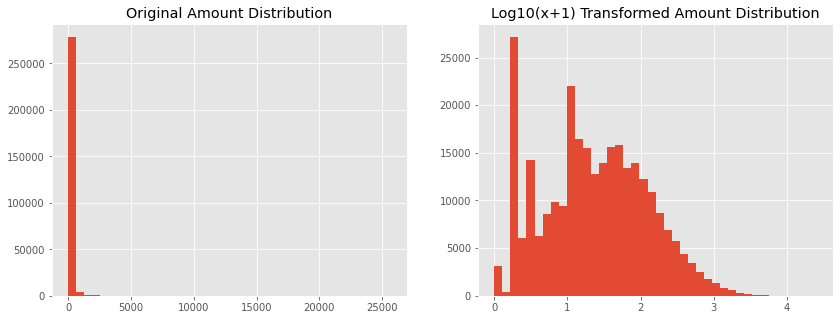

    count
0  284315
1     492


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
data = pd.read_csv("/content/drive/MyDrive/creditcard.csv")
data.head(3)

label_cols = ['Class']
data_cols = list(data.columns[ data.columns != 'Class' ])


# Total nulls in dataset (sum over rows, then over columns)

data.isnull().sum().sum()
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(data['Amount'], bins=40)
plt.title('Original Amount Distribution')

plt.subplot(1,2,2)
d0 = np.log10( data['Amount'].values + 1 )
# d0 = np.log1p( data['Amount'].values ) / np.log(10)
plt.hist( d0, bins=40 )
plt.title('Log10(x+1) Transformed Amount Distribution')
plt.show()
data['Amount'] = d0

percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.0 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )
percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

percentiles
data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]

train = data

print( pd.DataFrame( [ [np.sum(train['Class']==i)] for i in np.unique(train['Class']) ], columns=['count'], index=np.unique(train['Class']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]

#splitting data for training and testing
x = data.drop("Class", axis=1)
y = data['Class']
#use startify to split. which use same ratio of classes
x_train,x_test,y_train_,y_test = train_test_split(x,y,test_size=0.1, random_state = 100, stratify=y)


x_train['Class']=y_train_
fraud = x_train.loc[ data['Class']==1 ].copy()
fraud = fraud[data_cols]
non_fraud = x_train.loc[ data['Class']==0 ].copy()
non_fraud = non_fraud[data_cols]


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 28 19:16:05 2020

@author: raghu
"""

# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import random 

dr_ls_acc, dr_lc_acc, df_ls_acc, df_lc_acc = [], [], [], []

# define the standalone discriminator model
def define_discriminator(in_shape=30):
    # image input
    in_image = Input(shape=(in_shape,))
  
    fe = Dense(512)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Dense(128)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(2, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt, metrics=['accuracy'])
    return model


def define_generator(latent_dim, n_classes=1):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(n_classes,))
    in_lat = Input(shape=(latent_dim,))
    merge = Concatenate()([in_lat, in_label])
  
    gen = Dense(128)(merge)
    gen = Activation('relu')(gen)


    gen = Dense(512)(merge)
    gen = Activation('relu')(gen)
 
    gen = Dense(1024)(gen)
    gen = Activation('relu')(gen)
    
    gen = Dense(30)(gen)
    #out_layer = Reshape((1, 28, 1))(gen)
    # define model
    model = Model([in_lat, in_label], gen)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    
    # expand to 3d, e.g. add channels
    #X = expand_dims(train, axis=-1)
    # convert from ints to floats
    #X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    #X = (X - 127.5) / 127.5
    #print(X.shape, trainy.shape)
    return [x_train, y_train_]

# select real samples
def generate_real_samples(n_samples):
  
    #ix = randint(0, len(fraud), int(n_samples/2))
    #x_fraud, labels_fr = fraud.iloc[ix].values, ones((int(n_samples/2), 1), dtype=int)

    #ix = randint(0, len(non_fraud), int(n_samples/2))
    #x_non_fraud, labels_non_fr = non_fraud.iloc[ix].values, zeros((int(n_samples/2), 1), dtype=int)
    
    #X = np.vstack([x_fraud,x_non_fraud])
    #labels = np.vstack([labels_fr,labels_non_fr])

    ix = randint(0, len(x_train), int(n_samples))
    k = x_train.drop(columns='Class')
    X = k.iloc[ix].values
    labels = y_train_.iloc[ix].values

    y = ones((n_samples, 1), dtype=int)
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=2):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1), dtype=int)
    return [images, labels_input], y

def generate_real_samples_for_disc_test( n_samples=1):

    ix = randint(0, len(non_fraud), n_samples)
    X, labels = non_fraud.iloc[ix].values, zeros((1, 1), dtype=int)
    if random.choice([True, False]):
        ix = randint(0, len(fraud), n_samples)
        X, labels = fraud.iloc[ix].values, ones((1, 1), dtype=int)
        
    # generate class labels
    y = ones((n_samples, 1), dtype=int)
    return [X, labels], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, d_model, n_samples=100):
    # save the generator model
    filename2 = '/content/sample_data/cache/g_model_%04d.h5' % (step+1)
    g_model.save(filename2)
    # save the disc model
    filename2 = '/content/sample_data/cache/d_model_%04d.h5' % (step+1)
    d_model.save(filename2)
    print('Testing disc %s' % (step+1))
    [X_test_, X_test_label], _ = generate_real_samples_for_disc_test()
    out_ls, out_lc = d_model.predict(X_test_)
    print('Real Label %s and pred label %s and LS: %s' % (X_test_label,out_lc,out_ls))

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=5, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(x_train) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples( half_batch)
        # update discriminator model weights
        _,d_r1,d_r2, _dr_ls_acc, _dr_lc_acc = d_model.train_on_batch(X_real, [y_real, labels_real])
        dr_ls_acc.append(_dr_ls_acc)
        dr_lc_acc.append(_dr_lc_acc)
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2, _df_ls_acc, _df_lc_acc = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        df_ls_acc.append(_df_ls_acc)
        df_lc_acc.append(_df_lc_acc)
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        #print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (500) == 0:
            print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
            summarize_performance(i, g_model, latent_dim, d_model)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)

# train model
train(generator, discriminator, gan_model, latent_dim)

>500, dr[0.244,0.014], df[0.329,0.084], g[1.987,0.100]
Testing disc 500
Real Label [[1]] and pred label [[0. 1.]] and LS: [[0.9999995]]
>1000, dr[0.335,0.077], df[0.229,0.061], g[2.817,0.032]
Testing disc 1000
Real Label [[1]] and pred label [[0.9893707  0.01062931]] and LS: [[0.9660195]]
>1500, dr[0.533,0.090], df[0.367,0.122], g[2.554,0.030]
Testing disc 1500
Real Label [[0]] and pred label [[0.18626462 0.81373537]] and LS: [[0.13481145]]
>2000, dr[0.565,0.195], df[0.177,0.131], g[2.319,0.068]
Testing disc 2000
Real Label [[1]] and pred label [[1.1312757e-06 9.9999893e-01]] and LS: [[0.9787119]]
>2500, dr[0.331,0.076], df[0.217,0.038], g[2.771,0.026]
Testing disc 2500
Real Label [[1]] and pred label [[9.9998987e-01 1.0132619e-05]] and LS: [[0.75619745]]
>3000, dr[0.286,0.118], df[0.357,0.032], g[2.382,0.182]
Testing disc 3000
Real Label [[0]] and pred label [[1.000000e+00 6.207766e-09]] and LS: [[0.9991059]]
>3500, dr[0.339,0.328], df[0.319,0.119], g[2.089,0.052]
Testing disc 3500
Re

In [5]:
k = x_train.iloc[[2,1]].values
print(k)
X = k[:,-1]
print(X)

[[-0.50497039  0.55959996 -1.01853429  0.67733242 -0.22156144 -1.64152552
  -0.35887585 -1.01116842  0.04472907  0.0877324   0.6025388  -0.74312512
  -1.12382936 -0.85255588 -0.51177026  0.5891706   1.56561745  0.59829318
  -1.05696833  0.57263314  0.78854957  1.02887959  1.15637328 -0.62311732
   0.72349811  0.74805513 -0.10456567  0.06944314  0.30891924  1.32548627
   0.        ]
 [-0.76914919 -0.31639677  0.60175057  1.08349797  1.00346763  0.07267201
   0.23621748  0.57015379  0.33908624 -0.39516598  0.1440458   1.16333456
   0.46171991 -1.23803927  0.51173846 -0.42086685 -1.25566133  0.78570149
  -0.1323381   1.26671673  0.38295511  0.1819746   0.51333226 -0.07035566
   0.36758809 -0.31034182 -0.51965485  1.3958822   1.01090058  0.33882961
   0.        ]]
[0. 0.]


In [6]:
fraud.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
74496,-0.81919,-4.059498,1.80459,-5.407665,3.976655,-2.484771,-1.477707,-9.286759,0.501107,-3.700026,-9.866438,5.984809,-9.446152,-1.777303,-11.229681,0.187395,-9.31023,-18.670206,-5.506675,3.283168,0.203593,-0.332691,0.811902,-1.446268,-0.836933,-0.610304,-0.32913,4.031331,1.89208,-1.584605


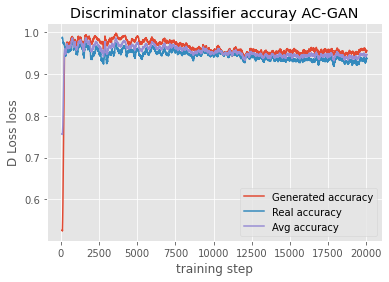

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
w = 100
plt.title('Discriminator classifier accuray AC-GAN')
# plt.plot( list(range(0,5001,1)), pd.rolling_mean((np.array(disc_loss_real) - np.array(disc_loss_generated)),w) )
plt.plot(pd.DataFrame(df_lc_acc).rolling(w).mean()  ,label='Generated accuracy') ;
plt.plot(pd.DataFrame(dr_lc_acc).rolling(w).mean()  ,label='Real accuracy') ;
plt.plot(pd.DataFrame(np.add(dr_lc_acc[:67560],df_lc_acc[:67560])*0.5).rolling(w).mean()  ,label='Avg accuracy') ;
plt.ylabel("D Loss loss")
plt.xlabel('training step')
plt.legend()
plt.show()

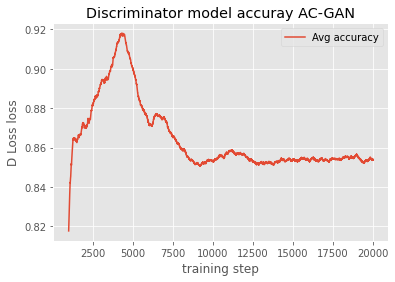

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
w = 1000
plt.title('Discriminator model accuray AC-GAN')
# plt.plot( list(range(0,5001,1)), pd.rolling_mean((np.array(disc_loss_real) - np.array(disc_loss_generated)),w) )
#plt.plot(pd.DataFrame(df_ls_acc).rolling(w).mean()  ,label='Generated accuracy') ;
#plt.plot(pd.DataFrame(dr_ls_acc).rolling(w).mean()  ,label='Real accuracy') ;
plt.plot(pd.DataFrame(np.add(dr_ls_acc[:67560], df_ls_acc[:67560])*0.5).rolling(w).mean()  ,label='Avg accuracy') ;
plt.ylabel("D Loss loss")
plt.xlabel('training step')
plt.legend()
plt.show()

In [9]:
def get_data_batch(train, batch_size, seed=0):
   
    # iterate through shuffled indices, so every sample gets covered evenly
    start_i = (batch_size * seed) % len(train)
    stop_i = start_i + batch_size
    shuffle_seed = (batch_size * seed) // len(train)
    np.random.seed(shuffle_seed)
    train_ix = np.random.choice( list(train.index), replace=False, size=len(train) ) # wasteful to shuffle every time
    train_ix = list(train_ix) + list(train_ix) # duplicate to cover ranges past the end of the set
    x = train.loc[ train_ix[ start_i: stop_i ] ].values
    
    return np.reshape(x, (batch_size, -1) )

In [10]:
print((get_data_batch(x_train, 100)))

[[ 1.35129926 -0.1704876  -1.02089524 ...  0.57244444  1.79595077
   0.        ]
 [-0.9498337   0.59192268  0.13216672 ...  0.16847708 -1.96382705
   0.        ]
 [-1.48244469 -0.05705671  1.15162674 ...  0.76162171 -0.65971593
   0.        ]
 ...
 [-0.70481648  0.67494403  0.37217116 ...  0.17099404 -1.60908001
   0.        ]
 [ 1.14830566 -0.52377538 -0.38641558 ...  1.78139638  2.1083512
   0.        ]
 [ 1.36969523  1.17209532  0.18075711 ... -0.19371137 -1.957583
   0.        ]]


1000
3000
6000
8000
9000
11000
12000
13000
14500
15000
16000
17000
18000
19000
20000


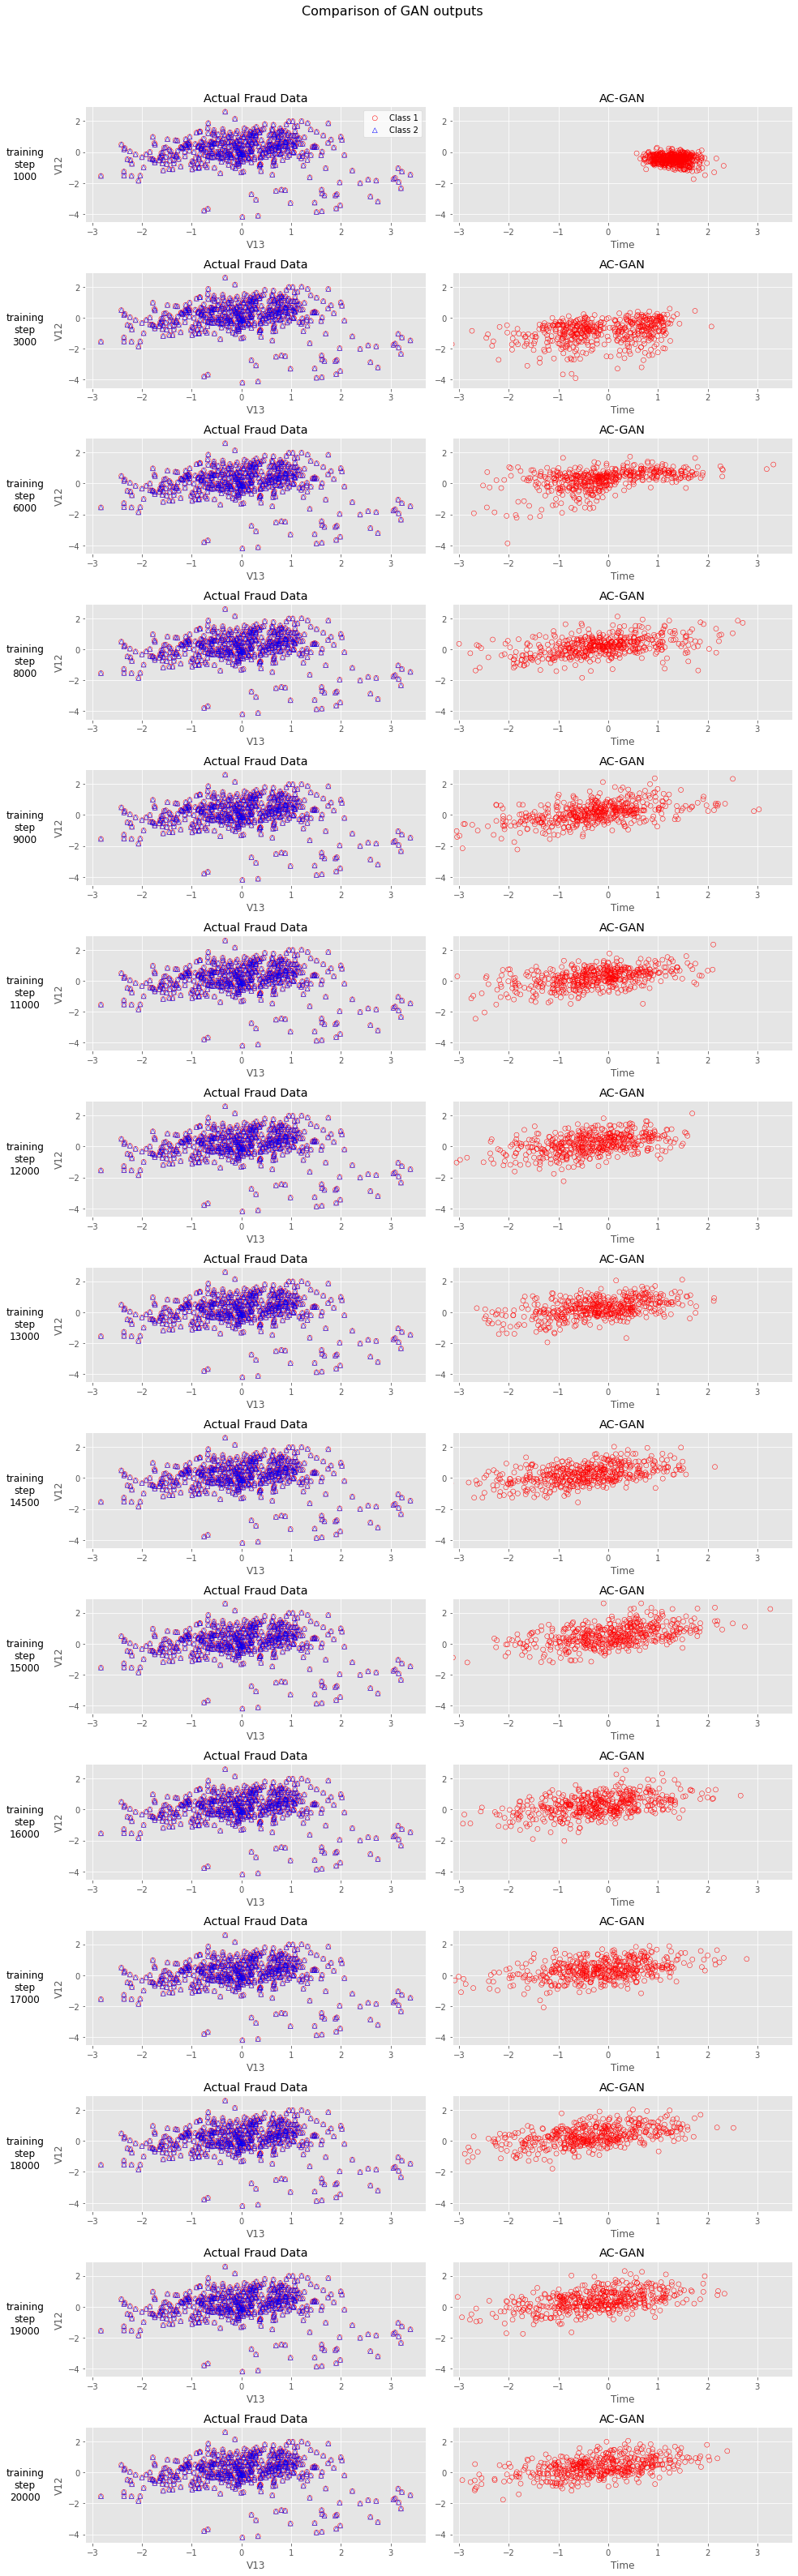

In [11]:
model_names = ['AC-GAN']
models = {}

for model_name in (model_names ):
    generator_model = define_generator(100)   
    models[model_name] = [ model_name, generator_model ]


model_steps = [  1000, 3000, 6000, 8000, 9000, 11000, 12000, 13000, 14500, 15000,16000, 17000,18000,19000,20000]
rows = len(model_steps)
columns = 2
col1, col2 = 'V13', 'V12'
class_labels = ['Class 1','Class 2']
colors = ['red','blue']
markers = ['o','^']
axarr = [[]]*len(model_steps)
test_size = 500
rand_dim= 100
real_samples = pd.DataFrame(get_data_batch(x_train.drop(columns='Class'),test_size), columns=data_cols)

z = np.random.normal(size=(test_size, rand_dim))
    # generate labels
labels = randint(0, 2, test_size)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate( model_steps ):
    print(model_step)
        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for  color, marker, label in zip( colors, markers, class_labels ):
        plt.scatter( real_samples[[col1]], real_samples[[col2]], 
                        label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
        
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):
        
        [ model_name, generator_model ] = models[model_name]
        
        generator_model.load_weights( '/content/sample_data/cache/g_model_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )
        
    
        g_z = generator_model.predict([z,labels])
        gen_samples = pd.DataFrame(g_z, columns=data_cols)
        plt.scatter( gen_samples[[col1]], gen_samples[[col2]], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)


plt.suptitle('Comparison of GAN outputs', size=16)
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

In [22]:
   #Testing classifier on test da
discriminator_test = define_discriminator()
discriminator_test.load_weights( '/content/sample_data/cache/d_model_'+str(2500)+'.h5')

_, classfier_prob = discriminator_test.predict(x_test)
#print(y_test)
#print(classfier_prob)

predict_class = np.argmax(classfier_prob, axis=1)

#print(predict_class)
print(pd.DataFrame(predict_class).value_counts().values[1])
#print(pd.DataFrame(y_test).value_counts())
model_steps = range(1000,20000,500)
probs = []
print(pd.DataFrame(y_test).value_counts().values[1])
for i, model_step in enumerate( model_steps ):       
        [ model_name, generator_model ] = models[model_name]       
        discriminator_test.load_weights( '/content/sample_data/cache/d_model_'+str(model_step)+'.h5')
        _, classfier_prob = discriminator_test.predict(x_test)
        predict_class = np.argmax(classfier_prob, axis=1)
        probs.append((pd.DataFrame(predict_class).value_counts().values[1]))
        print(model_step ,(pd.DataFrame(predict_class).value_counts().values[1]))

print(probs[:600000])   
#plt.plot(pd.DataFrame(dr_ls_acc).rolling(w).mean()  ,label='Real accuracy') ;
plt.plot(pd.DataFrame(probs[:60000]).rolling(1).mean()  ,label='Fraud Count with Training step') ;
plt.ylabel("Fraud Count on test data with with train step discriminator")
plt.xlabel('training step')
plt.legend()

2272
49
[[9.9995863e-01 4.1415100e-05]
 [9.9999928e-01 7.2101244e-07]
 [9.8708367e-01 1.2916307e-02]
 ...
 [9.9917918e-01 8.2082365e-04]
 [9.9960107e-01 3.9892163e-04]
 [9.9743927e-01 2.5607613e-03]]
1000 1872
[[9.6371365e-01 3.6286343e-02]
 [9.7314972e-01 2.6850248e-02]
 [9.9977320e-01 2.2679346e-04]
 ...
 [9.0074235e-01 9.9257708e-02]
 [9.9993539e-01 6.4626707e-05]
 [9.8013765e-01 1.9862309e-02]]
1500 2091
[[9.9999630e-01 3.7487537e-06]
 [1.0000000e+00 1.5537504e-08]
 [9.9978203e-01 2.1796610e-04]
 ...
 [9.9925357e-01 7.4640970e-04]
 [1.0000000e+00 2.3801054e-09]
 [1.0000000e+00 6.5662435e-09]]
2000 928
[[9.9999225e-01 7.7942732e-06]
 [9.9929130e-01 7.0865051e-04]
 [7.3144384e-02 9.2685562e-01]
 ...
 [9.7309291e-01 2.6907006e-02]
 [9.9806148e-01 1.9384723e-03]
 [1.0000000e+00 1.3099964e-09]]
2500 2272


KeyboardInterrupt: ignored

In [19]:
discriminator_test = define_discriminator()
discriminator_test.load_weights( '/content/sample_data/cache/d_model_'+str(5000)+'.h5')

_, classfier_prob = discriminator_test.predict(x_train.drop(columns='Class'))
#print(y_test)
#print(classfier_prob)

predict_class = np.argmax(classfier_prob, axis=1)

#print(predict_class)
print(pd.DataFrame(predict_class).value_counts().values[1])
print(pd.DataFrame(y_train_).value_counts().values[1])

6453
443
